# Advanced Raster Analysis

## Learning objectives
- Carry out a supervised classification on a SpatRaster
- Construct a raster sieve using the patches() function
- Deal with thematic (categorical maps)

# Introduction to Sentinel-2 data used here

We will carry out a supervised classification using Sentinel 2 data for the Gewata region in Ethiopia. To do this, we use atmospherically corrected Level 2A data acquired on December 27, 2020. These data were downloaded from ESA’s online data hub, a part of the Copernicus European Programme. As it is freely available, Sentinel data has been commonly used next to Landsat data for environmental monitoring.

![Landsat.v.Sentinel-2](../figs/Landsat.v.Sentinel-2.jpg)

# Notebook Setup

In [56]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
# import earthpy as et
# import earthpy.spatial as es
# import earthpy.plot as ep

import rasterio as rio
from rasterio import Affine # or from affine import Affine
from rasterio.mask import mask
from shapely.geometry import mapping, # Point
# from shapely.plotting import plot_polygon

from scipy.stats import pearsonr

from tqdm.auto import tqdm

In [2]:
ROOT_DIR = Path(os.getcwd()).parent
DATA_DIR = ROOT_DIR / 'data'

PYTHON_DIR = ROOT_DIR / 'python'
PYTHON_DATA_DIR = PYTHON_DIR / 'data'

In [3]:
raster_path = PYTHON_DATA_DIR / 'S2B2A_T36NZP_20201227T075239_20m_gewata_crop.tif' # the path to your imagery (raster)
bands_file_path = PYTHON_DATA_DIR / "S2B2A_T36NZP_20201227T075239_20m_gewata_bands.txt"

# Data exploration
Download the data to your computer and open your preferred R IDE to the directory of this tutorial.

After downloading the data we begin with visualization. The data consists of all the Sentinel-2 bands at a spatial resolution (or pixel size) of 20 m, meaning that each pixel on the scene corresponds to a ground distance of 20 m by 20 m. We will also make use of training polygons for the land cover classification, which will be introduced later.

In [4]:
with open(bands_file_path, "r") as f:
    band_names = f.readlines()
band_names = [name.strip() for name in band_names]

gewata = rxr.open_rasterio(raster_path)
gewata

<xarray.DataArray (band: 10, y: 1362, x: 2322)> Size: 63MB
[31625640 values with dtype=int16]
Coordinates:
  * band         (band) int64 80B 1 2 3 4 5 6 7 8 9 10
  * x            (x) float64 19kB 8.068e+05 8.068e+05 ... 8.532e+05 8.532e+05
  * y            (y) float64 11kB 8.495e+05 8.494e+05 ... 8.223e+05 8.222e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [5]:
# Convert DataArray to Dataset
gewata_ds = gewata.to_dataset(dim="band")

# Get the original band names
original_band_names = gewata.band.values

# Rename the data variables
rename_dict = {original_band_names[i]: band_names[i] for i in range(len(original_band_names))}
gewata_ds = gewata_ds.rename(rename_dict)

In [6]:
# Sanity check, look at the "data variables", if the renaming is successful, the data variables will be the same as the band names
gewata_ds

<xarray.Dataset> Size: 63MB
Dimensions:      (y: 1362, x: 2322)
Coordinates:
  * x            (x) float64 19kB 8.068e+05 8.068e+05 ... 8.532e+05 8.532e+05
  * y            (y) float64 11kB 8.495e+05 8.494e+05 ... 8.223e+05 8.222e+05
    spatial_ref  int64 8B 0
Data variables:
    B02          (y, x) int16 6MB ...
    B03          (y, x) int16 6MB ...
    B04          (y, x) int16 6MB ...
    B05          (y, x) int16 6MB ...
    B06          (y, x) int16 6MB ...
    B07          (y, x) int16 6MB ...
    B11          (y, x) int16 6MB ...
    B12          (y, x) int16 6MB ...
    B8A          (y, x) int16 6MB ...
    SCL          (y, x) int16 6MB ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [7]:
# Convert Dataset back to DataArray
gewata = gewata_ds.to_array(dim="band")

# The image is cloud-free, so drop the cloud mask layer
gewata = gewata.drop_sel(band="SCL")

In [ ]:
# Calculate number of rows and columns for subplots
num_bands = len(gewata.band)
num_cols = 3  # Adjust the number of columns as desired
num_rows = (num_bands + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=(15, 3*num_rows),
    # sharex=True,
    sharey=True
    )

# Flatten axes if needed
axes = axes.flatten()

# Plot histograms for each band
for i, band in enumerate(gewata):
    ax = axes[i]
    ax.hist(band.values.ravel(), bins=50)
    
    # Add a vertical line for the mean
    mean_value = band.mean().values
    ax.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
    # ax.legend()
    
    ax.set_title(f'Histogram of {band.band.values}')
    if i % num_cols == 0:
        ax.set_ylabel('Frequency')
    if i >= num_bands - num_cols:
        ax.set_xlabel('Pixel Value')

plt.tight_layout()
plt.show()

![q1_histogram](./figure/q1_1_histogram.png)

In [9]:
# Calculate summary statistics for all bands
summary_data = []
for band in gewata:
    summary_data.append({
        "Band": band.band.values.item(),
        "Mean": float(band.mean().values),
        "Std Dev": float(band.std().values),
        "Min": float(band.min().values),
        "Max": float(band.max().values)
    })

# Convert summary data to DataFrame
summary_df = pd.DataFrame(summary_data)

# Print the summary DataFrame
print("Summary Statistics for all Bands:")
summary_df

Summary Statistics for all Bands:


,Band,Mean,Std Dev,Min,Max
0,B02,320.891652,96.878144,28.0,4466.0
1,B03,523.778370,146.013377,41.0,5115.0
2,B04,404.278885,194.292647,33.0,5365.0
3,B05,864.573163,235.896180,91.0,4989.0
4,B06,2250.752617,407.851255,257.0,8790.0
5,B07,2759.374131,516.482874,326.0,10546.0
6,B11,1725.436172,433.437046,194.0,6982.0
7,B12,908.699626,351.494109,41.0,14146.0
8,B8A,3042.925266,545.979949,172.0,11008.0


Note that the values of these bands have been rescaled by a factor of 10,000. This is done for file storage considerations. For example, a value of 0.5643 stored as a float takes up more disk space than a value of 5643 stored as an integer. If you prefer reflectance values in their original scale (from 0 to 1), this can easily be done using raster algebra or app(). We will do this later.

In [10]:
# convert DataSet into pandas DataFrame
gewata_df = gewata_ds.to_dataframe()

# from all the raster value, randomly pick 1000 cells from each bands
sampled_df = gewata_df.sample(n=1000, random_state=42)
sampled_df = sampled_df.drop(columns=['SCL', 'spatial_ref']) # drop unused column for visualization

In [ ]:
# https://stackoverflow.com/questions/63416894/correlation-values-in-pairplot
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    text_color = plt.cm.RdYlBu((r + 1) / 2)  # Map correlation value to color
    text_size = abs(r) * 20  # Scale text size based on absolute correlation value
    ax.annotate(
        'r = {:.2f}'.format(r),
        xy=(0.5, 0.5),
        xycoords='axes fraction',
        ha='center',
        # color=text_color,
        fontsize=text_size
    )
    ax.set_axis_off()

g = sns.PairGrid(sampled_df)
g.map_diag(sns.histplot)
g.map_lower(sns.histplot)
g.map_upper(reg_coef)

![q1_pairplot](./figure/q1_2_pairplot.png)

<div class="alert alert-block alert-success">
<h2><b>Question 1:</b> Given what we know about the location of these bands along the EM spectrum, how could these scatterplots be explained?</h2>
</div>

<details>
<summary>Click to see answer.</summary>

Starting with bands 2 to 4, these correspond to the visible wavelengths of light, bands 5 and 6 are in the red edge region, 7, and 8a occupy the near infra-red (NIR) , while bands 11 and 12 are in the shortwave infrared (SWIR) region. An abrupt change occurs in the red to near infra-red region from around 680 to 800in our case this is demonstrated by the high variance and low correlation between bands 5 and 6.

</details>

In the [previous tutorial](https://geoscripting-wur.github.io/IntroToRaster/index.html#subsetting-layers-from-spatraster), we explored two ways to calculate NDVI, using direct raster algebra or using app(). Since we will be using NDVI again later in this tutorial, let’s calculate it again and store it in our workspace using app().

In [12]:
# Assuming your data has NIR and Red bands named 'NIR' and 'Red' respectively
nir_band = gewata.sel(band="B8A")
red_band = gewata.sel(band="B04")

# Calculate NDVI
ndvi = (nir_band - red_band) / (nir_band + red_band)

# Add a 'band' coordinate to the NDVI DataArray
ndvi = ndvi.expand_dims({'band': ['NDVI']}, axis=0) 

In [ ]:
# Plot NDVI
plt.figure(figsize=(10, 6))
ndvi.squeeze().plot.imshow(cmap='RdYlGn')
plt.title('NDVI')
plt.yticks(rotation=90) # Reorient y-axis tick labels
plt.show()

![q2_ndvi](./figure/q2_ndvi.png)

<div class="alert alert-block alert-success">
<h2><b>Question 2:</b> What is the advantage of including the NDVI layer in the land cover classification?</h2>
Hint: For information on NDVI, check out <a href="https://gisgeography.com/ndvi-normalized-difference-vegetation-index/" target="_blank">this source</a>.
</div>

<details>
<summary>Click to see answer.</summary>
It adds additional information which the model could use to classify the pixels.
</details>

# Classifying raster data

One of the most important tasks in analysis of remote sensing image analysis is image classification. In classifying the image, we take the information contained in the various bands (possibly including other synthetic bands such as NDVI or principal components). There are two approaches for image classification: supervised and unsupervised. In this tutorial we will explore supervised classification based on the Random Forest method.

## Supervised classification: Random Forest

The Random Forest classification algorithm is an ensemble learning method that is used for both classification and regression. In our case, we will use the method for classification purposes. Here, the Random Forest method takes random subsets from a training dataset and constructs classification trees using each of these subsets. Trees consist of branches and leaves.

Branches represent nodes of the decision trees, which are often thresholds defined for the measured (known) variables in the dataset. Leaves are the class labels assigned at the termini of the trees. Sampling many subsets at random will result in many trees being built. Classes are then assigned based on classes assigned by all of these trees based on a majority rule, as if each class assigned by a decision tree were considered to be a vote.

The figure below gives a simple demonstration of how the random forest method works in principle. For an introduction to the Random Forest algorithm, see this [presentation](https://www.slideshare.net/0xdata/jan-vitek-distributedrandomforest522013). For more information on random forest implementation in R see this tutorial.

![randomForestDescription](../figs/randomForestDescription.png)

One major advantage of the Random Forest method is the fact that an Out Of the Bag (OOB) cross-validation error estimate and an estimate of variable performance are performed. For each classification tree assembled, a fraction of the training data are left out and used to compute the error for each tree by predicting the class associated with that value and comparing with the already known class. This process results in a confusion matrix, which we will explore in our analysis. In addition an importance score is computed for each variable in two forms: the mean decrease in accuracy for each variable, and the Gini impurity criterion, which will also be explored in our analysis.

To perform the classification in R, it is best to assemble all covariate layers (ie. those layers containing predictor variable values) into one SpatRaster object. In this case, we can simply append the new layer (NDVI) to our existing SpatRaster (currently consisting of different bands).

First, let’s rescale the original reflectance values to their original scale. This step is not required for the RF classification, but it might help with the interpretation, if you are used to thinking of reflectance as a value between 0 and 1. (On the other hand, for very large raster bricks, it might be preferable to leave them in their integer scale, but we won’t go into more detail about that here.)

In [ ]:
# add ndvi band to original raster
gewata_with_ndvi = xr.concat([gewata, ndvi], dim='band')

# rescaling
gewata_with_ndvi = gewata_with_ndvi / 10000

gewata_with_ndvi

<xarray.DataArray (band: 10, y: 1362, x: 2322)> Size: 253MB
array([[[4.30000000e+02, 4.29000000e+02, 4.27000000e+02, ...,
         1.89000000e+02, 2.06000000e+02, 2.51000000e+02],
        [4.50000000e+02, 4.22000000e+02, 4.02000000e+02, ...,
         1.94000000e+02, 2.50000000e+02, 2.27000000e+02],
        [4.32000000e+02, 4.07000000e+02, 3.49000000e+02, ...,
         2.11000000e+02, 2.43000000e+02, 2.03000000e+02],
        ...,
        [3.01000000e+02, 3.01000000e+02, 2.70000000e+02, ...,
         3.72000000e+02, 4.91000000e+02, 3.77000000e+02],
        [2.86000000e+02, 2.87000000e+02, 2.84000000e+02, ...,
         3.70000000e+02, 4.33000000e+02, 3.83000000e+02],
        [2.67000000e+02, 2.64000000e+02, 2.86000000e+02, ...,
         3.35000000e+02, 3.70000000e+02, 3.49000000e+02]],

       [[8.89000000e+02, 8.88000000e+02, 8.37000000e+02, ...,
         3.42000000e+02, 3.56000000e+02, 4.52000000e+02],
        [9.08000000e+02, 8.72000000e+02, 7.82000000e+02, ...,
         3.28000000e+02, 4.54000000e+02, 4.20000000e+02],
        [8.72000000e+02, 7.68000000e+02, 6.28000000e+02, ...,
         3.63000000e+02, 4.37000000e+02, 3.73000000e+02],
...
        [2.98000000e+03, 2.48700000e+03, 2.90400000e+03, ...,
         2.38500000e+03, 2.15000000e+03, 1.96700000e+03],
        [3.06700000e+03, 2.85700000e+03, 3.21000000e+03, ...,
         2.73800000e+03, 2.15500000e+03, 1.84000000e+03],
        [3.14100000e+03, 2.97600000e+03, 3.46600000e+03, ...,
         2.69300000e+03, 2.27800000e+03, 1.92900000e+03]],

       [[8.24568367e-01, 8.20028438e-01, 8.20629578e-01, ...,
         8.58794127e-01, 8.69158879e-01, 8.74429224e-01],
        [8.20517889e-01, 8.15723794e-01, 8.31876821e-01, ...,
         8.70752427e-01, 8.76494024e-01, 8.70396939e-01],
        [8.13828689e-01, 8.28771623e-01, 8.36871508e-01, ...,
         8.75931842e-01, 8.79955207e-01, 8.87860082e-01],
        ...,
        [8.17073171e-01, 8.04134929e-01, 8.38556505e-01, ...,
         5.65474237e-01, 3.75119923e-01, 4.73960285e-01],
        [8.29952267e-01, 8.43820587e-01, 8.59791425e-01, ...,
         6.43457383e-01, 4.54606817e-01, 4.31349669e-01],
        [8.62989324e-01, 8.54783422e-01, 8.43617021e-01, ...,
         6.75793404e-01, 5.45454545e-01, 5.15913556e-01]]])
Coordinates:
  * x            (x) float64 19kB 8.068e+05 8.068e+05 ... 8.532e+05 8.532e+05
  * y            (y) float64 11kB 8.495e+05 8.494e+05 ... 8.223e+05 8.222e+05
    spatial_ref  int64 8B 0
  * band         (band) object 80B 'B02' 'B03' 'B04' ... 'B12' 'B8A' 'NDVI'
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

<xarray.DataArray (band: 10, y: 1362, x: 2322)> Size: 253MB
array([[[4.30000000e-02, 4.29000000e-02, 4.27000000e-02, ...,
         1.89000000e-02, 2.06000000e-02, 2.51000000e-02],
        [4.50000000e-02, 4.22000000e-02, 4.02000000e-02, ...,
         1.94000000e-02, 2.50000000e-02, 2.27000000e-02],
        [4.32000000e-02, 4.07000000e-02, 3.49000000e-02, ...,
         2.11000000e-02, 2.43000000e-02, 2.03000000e-02],
        ...,
        [3.01000000e-02, 3.01000000e-02, 2.70000000e-02, ...,
         3.72000000e-02, 4.91000000e-02, 3.77000000e-02],
        [2.86000000e-02, 2.87000000e-02, 2.84000000e-02, ...,
         3.70000000e-02, 4.33000000e-02, 3.83000000e-02],
        [2.67000000e-02, 2.64000000e-02, 2.86000000e-02, ...,
         3.35000000e-02, 3.70000000e-02, 3.49000000e-02]],

       [[8.89000000e-02, 8.88000000e-02, 8.37000000e-02, ...,
         3.42000000e-02, 3.56000000e-02, 4.52000000e-02],
        [9.08000000e-02, 8.72000000e-02, 7.82000000e-02, ...,
         3.28000000e-02, 4.54000000e-02, 4.20000000e-02],
        [8.72000000e-02, 7.68000000e-02, 6.28000000e-02, ...,
         3.63000000e-02, 4.37000000e-02, 3.73000000e-02],
...
        [2.98000000e-01, 2.48700000e-01, 2.90400000e-01, ...,
         2.38500000e-01, 2.15000000e-01, 1.96700000e-01],
        [3.06700000e-01, 2.85700000e-01, 3.21000000e-01, ...,
         2.73800000e-01, 2.15500000e-01, 1.84000000e-01],
        [3.14100000e-01, 2.97600000e-01, 3.46600000e-01, ...,
         2.69300000e-01, 2.27800000e-01, 1.92900000e-01]],

       [[8.24568367e-05, 8.20028438e-05, 8.20629578e-05, ...,
         8.58794127e-05, 8.69158879e-05, 8.74429224e-05],
        [8.20517889e-05, 8.15723794e-05, 8.31876821e-05, ...,
         8.70752427e-05, 8.76494024e-05, 8.70396939e-05],
        [8.13828689e-05, 8.28771623e-05, 8.36871508e-05, ...,
         8.75931842e-05, 8.79955207e-05, 8.87860082e-05],
        ...,
        [8.17073171e-05, 8.04134929e-05, 8.38556505e-05, ...,
         5.65474237e-05, 3.75119923e-05, 4.73960285e-05],
        [8.29952267e-05, 8.43820587e-05, 8.59791425e-05, ...,
         6.43457383e-05, 4.54606817e-05, 4.31349669e-05],
        [8.62989324e-05, 8.54783422e-05, 8.43617021e-05, ...,
         6.75793404e-05, 5.45454545e-05, 5.15913556e-05]]])
Coordinates:
  * x            (x) float64 19kB 8.068e+05 8.068e+05 ... 8.532e+05 8.532e+05
  * y            (y) float64 11kB 8.495e+05 8.494e+05 ... 8.223e+05 8.222e+05
    spatial_ref  int64 8B 0
  * band         (band) object 80B 'B02' 'B03' 'B04' ... 'B12' 'B8A' 'NDVI'

In [ ]:
# saving the raster, we will need this for data preparation process
ndvi_raster_name = "gewata_with_ndvi.tif"
ndvi_raster_path = PYTHON_DATA_DIR / ndvi_raster_name

if not os.path.exists(ndvi_raster_path):
    print('saving....')
    gewata_with_ndvi.rio.to_raster(PYTHON_DATA_DIR / "gewata_with_ndvi.tif")
    print(f'saved to {ndvi_raster_path}') 
else:
    print('{ndvi_raster_path} already exists, skipping process...')

saving....
saved as /home/arasyidi/project/1_learn/AdvancedRasterAnalysis/python/data/gewata_with_ndvi.tif


## Training data preparation
For this exercise, we will do a very simple classification for 2020 using three classes: forest, cropland and wetland. While for other purposes it is usually better to define more classes (and possibly fuse classes later), a simple classification like this one could be useful, for example, to construct a forest mask for the year 2020.

In [15]:
training_label = gpd.read_file(DATA_DIR / 'trainingPoly.csv')
training_label = training_label.set_crs(gewata_with_ndvi.rio.crs)
training_label = training_label.drop(columns=[
    'WKT',
    # 'Code'
    ]) # Drop WKT column as it is redundant with geometry column
training_label.head(3)

,OBJECTID,Class,geometry
0,1,wetland,"POLYGON ((821935.575 833523.320, 823504.654 83..."
1,2,wetland,"POLYGON ((824714.007 831022.839, 827669.137 83..."
2,3,wetland,"POLYGON ((830913.385 832637.370, 831328.993 83..."


Text(0.5, 1.0, 'Overlay Plot')

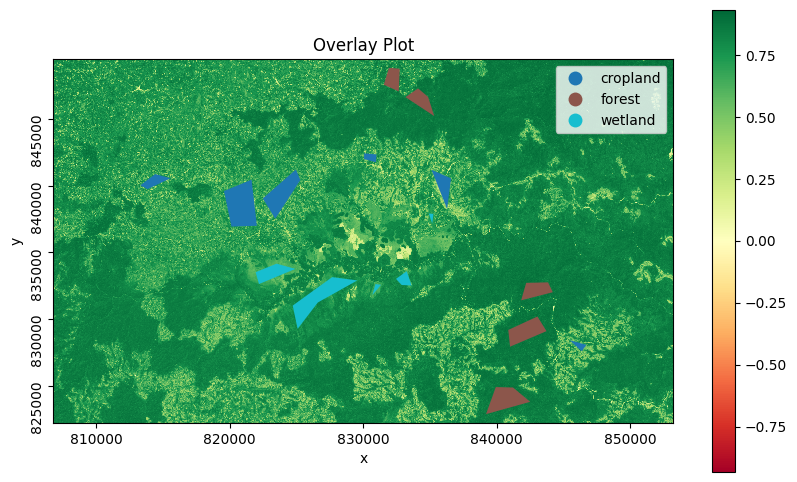

In [16]:
# Plot NDVI
fig, ax = plt.subplots(figsize=(10, 6))

ndvi.squeeze().plot.imshow(ax=ax, cmap='RdYlGn')
training_label.plot(
    column='Class',
    legend=True,
    ax=ax
    )

plt.yticks(rotation=90) # Reorient y-axis tick labels
plt.title('Overlay Plot')

The training classes are labelled as string labels. For this exercise, we will need to work with integer classes, so we will need to first ‘relabel’ our training classes. There are several approaches that could be used to convert these classes to integer codes.

In [17]:
# Convert the 'Class' column to a categorical dtype (factor in R)
training_label['Class'] = training_label['Class'].astype('category')

# Check summary statistics of the 'Class' column after conversion
training_label['Class'].describe()

count           16
unique           3
top       cropland
freq             6
Name: Class, dtype: object

In [18]:
# Make a new 'Code' column by converting the factor levels to integers
training_label['Code'] = training_label['Class'].cat.codes

# Inspect the new 'Code' column
training_label['Code'].describe()

count    16.000000
mean      0.937500
std       0.853913
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       2.000000
Name: Code, dtype: float64

In [19]:
# Define a colour scale for the classes (as above) corresponding to: cropland, forest, wetland
color_dict = {
    "cropland":"orange",
    "forest":"darkgreen",
    "wetland":"lightblue"
    }

<Axes: title={'center': 'band = NDVI, spatial_ref = 0'}, xlabel='x', ylabel='y'>

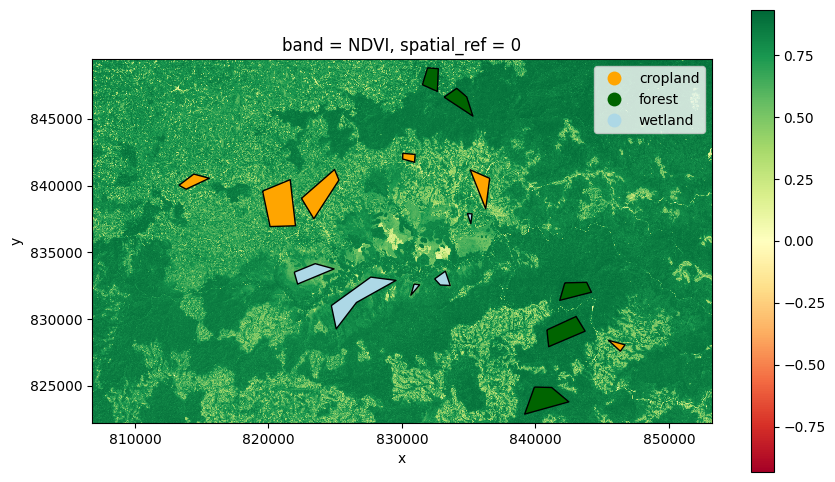

In [20]:
# Superimpose training polygons (color by class) onto NDVI plot
fig, ax = plt.subplots(figsize = (10,6))

ndvi.squeeze().plot.imshow(ax=ax, cmap='RdYlGn')

training_label.plot(
    column='Class',
    ax=ax,
    legend=True,
    cmap=colors.ListedColormap(list(color_dict.values())),
    edgecolor='black'
    )

Our goal in preprocessing this data is to have a table of values representing all layers (covariates) with known values/classes. To do this, we will first need to know the values of the covariates at our training polygon locations. We can use extract function of terra package for this. Next we convert these data to a data.frame representing all training data.

In [81]:
# https://gis.stackexchange.com/a/260380/140116

new_band_names = gewata_with_ndvi.band.values.tolist()
geoms_list = training_label.geometry.values
class_list = training_label.Class.values
code_list = training_label.Code.values

# for each polygon, extract the raster values
gdf_list = []
for geometry, _class, _code in tqdm(zip(geoms_list, class_list, code_list), total=len(code_list)):
    band_val_list = []
    
    # for each bands in 
    for i, band in enumerate(new_band_names):
        geoms_shp = [mapping(geometry)]
        
        with rio.open(ndvi_raster_path) as src:
            out_image, out_transform = mask(src, geoms_shp, crop=True)
        
        if src.nodata!=None:
            no_data = src.nodata
        else:
            no_data = 0
        
        band_values = out_image[i]
        
        row, col = np.where(band_values != no_data)
        band_val_clipped = np.extract(band_values != no_data, band_values)        
        
        d = pd.DataFrame({
            'row':row,
            'col':col,
            'class':_class,
            'code':_code,
            band:band_val_clipped
            })
        band_val_list.append(d)
    
    semi_final_gdf = pd.concat(band_val_list, axis=1)
    semi_final_gdf = semi_final_gdf.loc[:,~semi_final_gdf.columns.duplicated()].copy() # https://stackoverflow.com/a/40435354/9782019
    
    gdf_list.append(semi_final_gdf)

final_gdf = pd.concat(gdf_list)

# coordinate transformation
T1 = out_transform * Affine.translation(0.5, 0.5) # reference the pixel centre
rc2xy = lambda r, c: T1 * (c, r) # row col to xy

final_gdf['x'] = final_gdf.apply(lambda row: rc2xy(row.row,row.col)[0], axis=1)
final_gdf['y'] = final_gdf.apply(lambda row: rc2xy(row.row,row.col)[1], axis=1)

# add geometry
final_gdf = gpd.GeoDataFrame(
    final_gdf,
    geometry=gpd.points_from_xy(final_gdf.x, final_gdf.y),
    crs=training_label.crs
    )

final_gdf = final_gdf.reset_index().drop(columns=['index'])

  0%|          | 0/16 [00:00<?, ?it/s]

In [88]:
final_gdf.describe().T

,count,mean,std,min,25%,50%,75%,max
row,87204.0,62.389397,41.762706,0.000000,30.000000,53.000000,87.000000,192.000000
col,87204.0,65.623618,39.839297,0.000000,35.000000,59.000000,90.000000,241.000000
code,87204.0,0.835787,0.786837,0.000000,0.000000,1.000000,1.000000,2.000000
B02,87204.0,335.295709,105.709201,100.000000,223.000000,363.000000,414.000000,1679.000000
B03,87204.0,550.774747,152.504417,142.000000,406.000000,574.000000,683.000000,1924.000000
B04,87204.0,433.167871,197.869199,102.000000,235.000000,436.000000,564.000000,2110.000000
B05,87204.0,904.078918,229.008441,253.000000,694.000000,950.000000,1079.000000,2338.000000
B06,87204.0,2227.087679,402.332526,686.000000,1962.000000,2168.000000,2435.000000,3910.000000
B07,87204.0,2701.966194,502.075519,885.000000,2361.000000,2640.000000,2979.000000,5021.000000
B11,87204.0,1773.841464,471.738085,592.000000,1352.000000,1794.000000,2080.000000,3922.000000


In [77]:
1362*2322

3162564